## Practical Assignment 17.1: Comparing Classifiers

### Overview
This notebook follows a structured workflow aligned with the CRISP-DM framework to evaluate classification models for predicting client subscription to a term deposit in a bank marketing dataset. It begins with business and data understanding, followed by exploratory analysis and data preparation. Baseline and simple models are evaluated to establish performance benchmarks, before moving on to tuned models and comparative analysis. 

Visualizations and evaluation metrics are selected intentionally to support interpretation and decision-making, with a focus on handling class imbalance and assessing practical trade-offs rather than exhaustively exploring every variable.

#### Objective
The objective of this assignment is to evaluate and compare several classification models: Logistic Regression, K-Nearest Neighbors, Decision Trees, and Support Vector Machines, on the Bank Marketing dataset, with the goal of predicting whether a client will subscribe to a term deposit.

Given the low conversion rate for subscriptions, the dataset is strongly imbalanced. As a result, the model evaluation focuses not only on accuracy, but also on recall and precision, with particular emphasis on identifying potential subscribers. The analysis aims to understand both model performance and trade-offs, and to determine which approaches are most suitable for this business context.

#### Dataset
The data is sourced from the UCI Machine Learning Repository (Bank Marketing). It contains client attributes, details of the last campaign contact, campaign history, and broader macroeconomic indicators. The target variable is whether the client subscribed to a term deposit (y).

The original source provides multiple files. In this notebook I use:

- `bank-additional-full.csv` (41,188 rows) as the primary dataset for EDA and final model evaluation.

- `bank-additional.csv` (4,119 rows; ~10%) as a computational shortcut when exploring models that are expensive to tune (notably SVM). Any conclusions based on the reduced dataset are validated against the full dataset where feasible.

The dataset and its documentation are credited to Moro, Cortez, and Rita (2014). Bank Marketing, UCI Machine Learning Repository. https://doi.org/10.24432/C5K306.


#### Notebook Structure
This notebook, `Practical_Assignment_17.1_Jonathan_O'Dea.ipynb`, includes the following sections:

1. Business Understanding
2. Data Understanding & EDA
3. Initial assumptions
4. Data Preparation
5. Feature Handling
6. Baseline Modeling
7. Hyperparameter Optimization
   - Logistic Regression
   - K-Nearest Neighbors (KNN)
   - Decision Trees
   - Support Vector Machines (SVM)
8. Model Comparison
9. Findings & Recommendations
10. Next Steps


### Summary of Findings

Based on the Bank Marketing dataset and the analysis performed, this project shows that predicting client subscription to a term deposit is strongly affected by class imbalance, making accuracy alone an unreliable evaluation metric. Models that appear to perform well on accuracy may still fail to identify a meaningful number of actual subscribers.

Across the models evaluated, Logistic Regression provided the most practical and reliable performance. While it did not achieve the highest recall by default, it allowed recall to be increased through explicit threshold adjustment, while remaining computationally efficient and interpretable. Other models, such as KNN, Decision Trees, and SVM, were able to achieve comparable or higher recall under certain configurations, but did so with trade-offs that limited their practical usefulness, including higher computational cost, reduced precision, or limited controllability.

Overall, Logistic Regression offered the best balance between predictive performance and real-world applicability for the original business objective.

#### Actionable Ideas for the Bank

- Use a lower decision threshold to identify more potential subscribers, accepting a higher number of outreach attempts in exchange for increased conversions.
- Treat model outputs as a prioritisation tool rather than a definitive decision, focusing outreach efforts on higher-probability clients.
- Monitor the volume of additional contacts generated by lower thresholds to ensure outreach costs remain acceptable.

#### Next Steps for Future Modeling

- Perform a cost–benefit analysis to determine the optimal decision threshold based on marketing costs and expected revenue per subscription.
- Test the selected model and threshold in a controlled rollout to measure real-world performance before full deployment.
- Periodically review and adjust the model as client behaviour and economic conditions change.

### How to Run
1. The public project repository can be located at: https://github.com/Jonny802/Practical-Application-Assignment-17.1
2. Download the project files `Practical_Assignment_17.1_Jonathan_O'Dea.ipynb`, `bank-additional-full.csv`  and `bank-additional.csv` locally
3. Place the datasets inside a local /data folder
4. Run cells top-to-bottom.

---

----

### 1. Business Understanding

From the bank’s standpoint, the business goal is to improve the effectiveness of term deposit marketing by identifying which clients are more likely to subscribe. A practical use case is prioritizing outreach: if the bank can better identify likely subscribers, it can reduce unnecessary calls and focus effort where conversion probability is higher.

Given the low conversion rate for subscriptions, a useful model in this context should be able to capture subscribers (high recall), while still keeping false positives at a manageable level (precision trade-off). This framing directly influences metric selection and threshold tuning later in the notebook.

In this context, false negatives (missed subscribers) are more costly than false positives (unnecessary outreach), which further motivates a recall-focused evaluation.

----

### 2. Data Understanding & EDA

The dataset includes client demographics, loan status, the channel/timing of the last contact, previous campaign outcomes, and macroeconomic context variables. I first reviewed basic structure (dtypes, missing values, category levels, target balance), then used a small set of targeted plots to understand where successful subscriptions are concentrated and to justify metric selection under class imbalance.

Full variable definitions are included in the dataset description cell below for reference.

##### Dataset Description

**Input variables:**

**Bank client data:**
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
   
**Related with the last contact of the current campaign:** 

8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
    
**Other attributes:**

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
    
**Social and economic context attributes**

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):** 

21. y - has the client subscribed a term deposit? (binary: 'yes','no')

----

### 3. Initial Assumptions

Based on the dataset description and initial exploration, the following assumptions guide the analysis:

- The target variable is significantly imbalanced, meaning accuracy alone will not adequately reflect model performance.
- Recall is a critical metric, as failing to identify potential subscribers is more costly than contacting uninterested clients.
- Client demographics and campaign-related variables are expected to be more predictive than macroeconomic indicators at the individual level.
- Categorical variables will require encoding to be usable in most models.

----

### 4. Data Preparation

The datasets were reviewed for missing values and obvious inconsistencies. As the data was already clean and well-structured, no major cleaning or imputation was required. The focus was placed on understanding feature distributions and class imbalance rather than altering the original data.

#### 4.1 Imports and Data Loading

In [1]:
#--------------------------------------------
# Imports
#--------------------------------------------
import time, warnings, math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, 
precision_recall_curve, roc_curve, roc_auc_score, PrecisionRecallDisplay, auc
)
from sklearn.svm import SVC

#--------------------------------------------
# Warning Error Removal
#--------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

#--------------------------------------------
# Load data from CSV
#--------------------------------------------
# Bank-additional-full.csv with all examples (41188) and 20 inputs.
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

# Dank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
# Used in the improved SVM model due to the computational requirements.
df2 = pd.read_csv('data/bank-additional.csv', sep = ';')


#### 4.2 Initial DataFrame review

The datasets are already very clean, there are no missing values and no odd entries, making the data cleaning process tuning only to focus on the analysis attributes that were required, such as converting categorical data types to numerical in new columns.

The smaller dataset (`bank-additional.csv`) was also verified to being a 10% version of that of the complete dataset.

In [2]:
# --------------------------------------------
# Dataset Review
# --------------------------------------------

# All checks done to one dataset were perfomed to the other:
df.info()
df.nunique()
df.isnull().sum()
df['y'].unique()
df['y'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

y
no     36548
yes     4640
Name: count, dtype: int64

In [3]:
# Term deposit success rates between the datasets.
# The similar subscription rates suggest the reduced dataset is representative of the full dataset.

success_rate = df['y'].value_counts(normalize=True).sort_index().reset_index()
success_rate_2 = df2['y'].value_counts(normalize=True).sort_index().reset_index()

print(success_rate)
print()
print(success_rate_2)

     y  proportion
0   no    0.887346
1  yes    0.112654

     y  proportion
0   no    0.890507
1  yes    0.109493


#### 4.3 Data Cleaning

As mentioned above, the datasets do not require extensive cleaning steps such as missing-value imputation or outlier removal. Any data cleaning or modifications done were aimed to:

- Ensure the target is represented consistently as a binary variable
- Handle categorical variables correctly (encoding performed inside pipelines)

Because the original dataset uses y as the target name, I keep the column as-is in the raw dataframe but create a clearer modeling target name (subscribed) for readability in code and plots.

In [4]:
# Keep original column name 'y' in the dataframe, but create a clean binary target for modeling
df["subscribed"] = (df["y"] == "yes").astype(int)
df2["subscribed"] = (df2["y"] == "yes").astype(int)

In [5]:
# --------------------------------------------
# Convert everything to numerical format in order to generate a correlation matrix
# --------------------------------------------

# Note: For this step categorical variables were label-encoded only to enable a single heatmap in order to quickly gain a representation of ALL the
# relationships within the dataset to start a deeper analysis; these numeric codes do not represent true ordinal relationships, 
# this serves a purpose initially, however correct encoding for the models are generated accordingly.

df['job_num'] = df['job'].replace({'admin': 1,'blue-collar': 2, 'entrepreneur': 3, 'housemaid': 4, 'management': 5, 'retired': 6,
                                     'self-employed': 7, 'services': 8, 'student': 9, 'technician': 10, 'unemployed': 11})
df['marital_num'] = df['marital'].replace({'divorced': 1,'married': 2, 'single': 3, 'unknown': 4})
df['edu_num'] = df['education'].replace({'basic.4y': 1,'basic.6y': 2, 'basic.9y': 3, 'high.school': 4, 'professional.course': 5,
                                   'university.degree': 6, 'illiterate': 7, 'unknown': 8})
df['month_num'] = df['month'].replace({'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
df['day_num'] = df['day_of_week'].replace({'mon': 1,'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5})
df['pout_num'] = df['poutcome'].replace({'failure': 1,'success': 2, 'nonexistent': 3})
df['default_num'] = df['default'].replace({'no': 1,'yes': 2, 'unknown': 3})
df['house_num'] = df['housing'].replace({'no': 1,'yes': 2, 'unknown': 3})
df['loan_num'] = df['loan'].replace({'no': 1,'yes': 2, 'unknown': 3})
df['contact_num'] = df['contact'].replace({'cellular': 1,'telephone': 2})
df['y_num'] = df['y'].replace({'no': 0,'yes': 1})

In [6]:
# --------------------------------------------
# Split values into bins for easier visualization
# --------------------------------------------

# Euribor 3-month rate and apply limits:

# Define bin range
bin_amount = 0.25
min_val = df['euribor3m'].min()
max_val = df['euribor3m'].max()

# Set intervals: np.arange([start, ]stop, [step, ]
bins = np.arange(min_val, max_val + bin_amount, bin_amount)

# Cut up original column and make a new one with grouped bins (upper limit)
df['euribor3m_upper'] = pd.cut(df['euribor3m'], bins=bins, right=True, include_lowest=True)
euribor_binned = df.groupby(['euribor3m_upper', "y"]).size().unstack(fill_value=0)

# Age bins for life/ career phases:
age_bins = pd.cut(df["age"], bins=[17, 25, 35, 45, 55, 65, 75, 100])
age_counts_binned = df.groupby([age_bins, "y"]).size().unstack(fill_value=0)

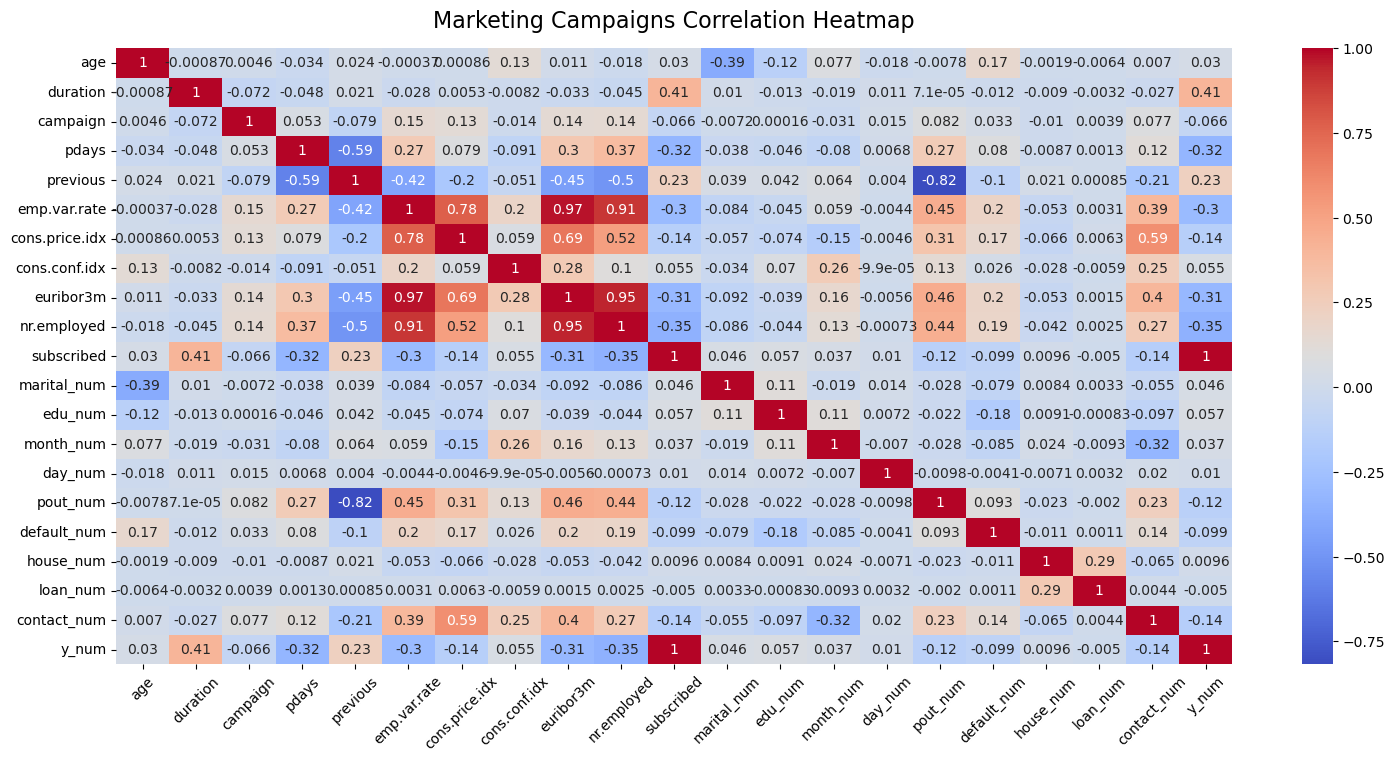

In [7]:
#--------------------------------------------
# Analyze correlations across entire dataset:
#--------------------------------------------

# As stated previously, this heatmap serves as a starter to evaluate relevant relationships to succesful term deposit subscriptions. 

numeric_df = df.select_dtypes(include = 'number')
corr = numeric_df.corr().fillna(0)
plt.figure(figsize=(18, 8))
sns.heatmap(data = numeric_df.corr(), annot = True, cmap = 'coolwarm')
plt.title('Marketing Campaigns Correlation Heatmap', size=16, y=1.02)
plt.xticks(rotation=45)
plt.show()

#### 4.4 Exploratory Analysis of Key Variables Relative to Subscription Outcome

The plots below illustrate __(1)__ the overall class imbalance, __(2)__ how positive subscription outcomes vary across age groups, and __(3–4)__ how outcomes are distributed across selected categorical and macroeconomic variables. These visualizations help identify which features are likely to be most informative for modeling, without attempting exhaustive exploration of every variable.

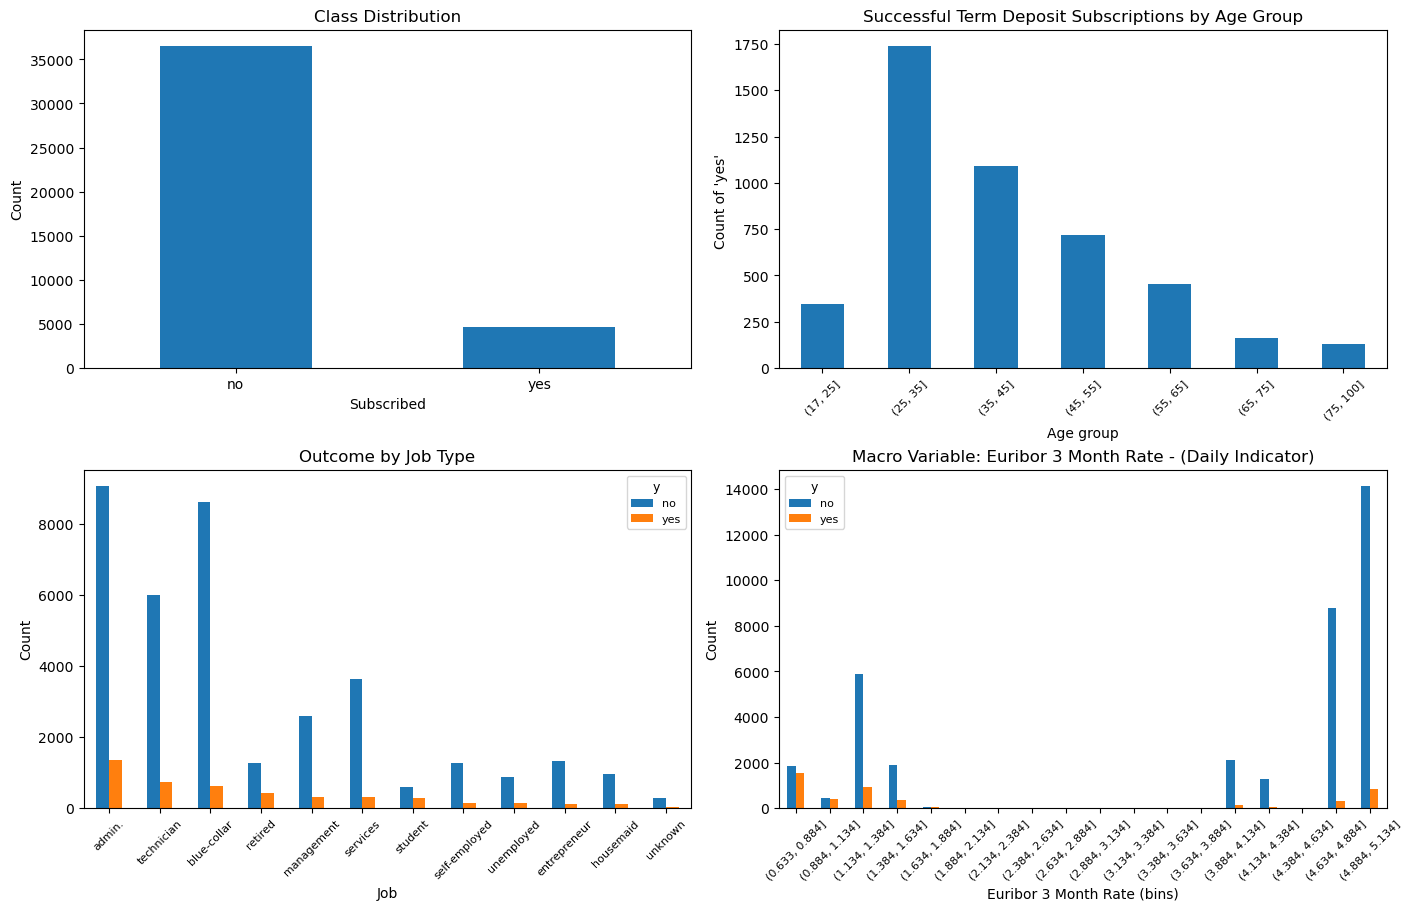

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 9), constrained_layout=True)

# 1) Class imbalance (target distribution)
df["y"].value_counts().plot(ax=axes[0, 0], kind="bar")
axes[0, 0].set_title("Class Distribution")
axes[0, 0].set_xlabel("Subscribed")
axes[0, 0].set_ylabel("Count")
axes[0, 0].tick_params(axis="x", rotation=0)

# 2) Subscriptions by age group
age_bins = pd.cut(df["age"], bins=[17, 25, 35, 45, 55, 65, 75, 100])
age_yes_counts = df.loc[df["y"] == "yes"].groupby(age_bins).size()
age_yes_counts.plot(ax=axes[0, 1], kind="bar")
axes[0, 1].set_title("Successful Term Deposit Subscriptions by Age Group")
axes[0, 1].set_xlabel("Age group")
axes[0, 1].set_ylabel("Count of 'yes' ")
axes[0, 1].tick_params(axis="x", rotation=45, labelsize=8)

# 3) Outcome by job type
job_counts = df.groupby(["job", "y"]).size().unstack(fill_value=0).sort_values("yes", ascending=False)
job_counts.plot(ax=axes[1, 0], kind="bar")
axes[1, 0].set_title("Outcome by Job Type")
axes[1, 0].set_xlabel("Job")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis="x", rotation=45, labelsize=8)
axes[1, 0].legend(title="y", fontsize=8, title_fontsize=9)

# 4) Outcome by macro variables - Euribor {euro interbank offered rate).
euribor_counts = df.groupby(["euribor3m_upper", "y"]).size().unstack(fill_value=0)
euribor_counts.plot(ax=axes[1, 1], kind="bar")
axes[1, 1].set_title("Macro Variable: Euribor 3 Month Rate - (Daily Indicator)")
axes[1, 1].set_xlabel("Euribor 3 Month Rate (bins)")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis="x", rotation=45, labelsize=8)
axes[1, 1].legend(title="y", fontsize=8, title_fontsize=9)

plt.show()

#### 4.5 Post Data Revision Analysis

From analyzing the data, along with using some domain knowledge in sales, the factors/ columns that have identified as being the most relevant to the successful subscription of a customer is the following:

- __Age:__&emsp; Subscription rates show a clear pattern across age groups, suggesting age is a meaningful differentiator.
- __Job type:__&emsp; Certain occupations exhibit consistently higher subscription rates, indicating differing financial behavior.
- __Contact method__&emsp; The method of contact appears to influence campaign success.
- __Previous campaign outcome__&emsp; Prior success strongly correlates with future subscription.
- __Housing loan__&emsp; Loan status may reflect financial flexibility.
- __Personal loa__&emsp; Similar to housing loans, this may indicate disposable income constraints.
- __Marital status__&emsp; Subscription behavior varies modestly across marital categories.
- __Education level__&emsp; Education appears linked to financial product adoption.


----

### 5. Feature Handling

The day, month and y (subscription) columns had previously been converted into numerical interger columns for the sake of finding initial correlations. However, in order to not put incorrect weighting on the variables, numerical and categorical columns were identified so that they could both be incorporated into a preprocessor for all of the models.

Categorical variables are encoded so they can be used by the models, while numerical variables are left in their original form unless scaling is required by the algorithm. This approach helps preserve interpretability and reduces the risk of introducing unnecessary complexity at this stage of the analysis.

In [9]:
# Define features (X) and target (y)
# Based on the problem description, these are the original features.
# 'duration' is included for benchmarking purposes.

# --------------------------------------------
# Primary data set
# --------------------------------------------

feature_columns = ['job', 'marital', 'education', 'contact', 'housing', 'loan', 'default', 'poutcome']

X = df[feature_columns]
y = df['y']

le = LabelEncoder()
y = le.fit_transform(y)

# Identify numerical and categorical columns for the preprocessor
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)])

# --------------------------------------------
# Secondary data set
# --------------------------------------------

feature_columns2 = ['job', 'marital', 'education', 'contact', 'housing', 'loan', 'default', 'poutcome']

X2 = df2[feature_columns2]
y2 = df2['y']

le2 = LabelEncoder()
y2 = le2.fit_transform(y2)

# Identify numerical and categorical columns for the preprocessor
numerical_columns2 = X2.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns2 = X2.select_dtypes(include=['object']).columns.tolist()

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num2', StandardScaler(), numerical_columns2),
        ('cat2', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns2)])

#### 5.1. Train/Test Split

In [10]:
# Simple train/test splits. 30% test size, assigned random state = 7.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, random_state = 7)

----

### 6. Baseline Modeling

The objective of the modeling phase was to compare the performance of several classification algorithms under a consistent and structured framework. To establish a reference point, a baseline model was first created. This was followed by the evaluation of multiple classification models using their default configurations to understand their base behaviour. Hyperparameters were then tuned using cross-validation in order to identify the best-performing version of each model. Finally, the models were compared using a common evaluation metric to assess their relative suitability for the given business objective.

#### 6.1. Baseline Model

In [11]:
# Establish a baseline performance that the classifier should aim to beat.
# Using two methods as a comparison:

baseline = df['y'].value_counts(normalize = True).max()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_preds = dummy_clf.predict(X_test)

print("Baseline:", baseline)
print("Baseline (most_frequent):")
print("Accuracy:", round(accuracy_score(y_test, dummy_preds), 3))
print("Precision:", precision_score(y_test, dummy_preds))
print("Recall:", recall_score(y_test, dummy_preds))

Baseline: 0.8873458288821987
Baseline (most_frequent):
Accuracy: 0.892
Precision: 0.0
Recall: 0.0


#### 6.2. Simple models

To first gauge an understanding of the base performances of the four models (Logistic Regression, KNN, Decision Trees, SVM), using the default settings for each of the models. They were then fit and scored. A data frame with the results can be found at the bottom of this section.

These models provide a performance baseline and help contextualize improvements from later tuning.

In [12]:
# Define the models and hyperparameters - standard in this case
models = {
    "log_reg": LogisticRegression(random_state=7),
    "knn": KNeighborsClassifier(),
    "dtree": DecisionTreeClassifier(random_state=7),
    "svc": SVC()
}

results = []

for name, model in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), (name, model)])
    
    start = time.time()
    pipe.fit(X_train, y_train)
    fit_time = time.time() - start

    # Scores (accuracy on train/test) 
    train_accuracy = pipe.score(X_train, y_train)
    test_accuracy = pipe.score(X_test, y_test)
    
    y_pred = pipe.predict(X_test)

    # Tree depth for Decision Tree
    tree_depth = np.nan
    if name == "dtree":
        tree_depth = pipe.named_steps[name].get_depth()
        
    results.append({
        "Model": name,
        "Train Time (s)": round(fit_time, 2),
        "Train Accuracy": round(train_accuracy, 3),
        "Test Accuracy": round(test_accuracy, 3),
        "Precision": round(precision_score(y_test, y_pred, zero_division=0), 3),
        "Recall": round(recall_score(y_test, y_pred, zero_division=0), 3),
        "Tree Depth": tree_depth
    })

results_df = pd.DataFrame(results).set_index("Model")
results_df

,Train Time (s),Train Accuracy,Test Accuracy,Precision,Recall,Tree Depth
Model,,,,,,
log_reg,0.10,0.896,0.900,0.643,0.166,NaN
knn,0.05,0.895,0.889,0.459,0.148,NaN
dtree,0.20,0.906,0.892,0.507,0.161,28.0
svc,13.36,0.897,0.899,0.627,0.176,NaN


##### 6.2.1. Simple Model Findings and Conclusion:

The simple models provide a useful baseline, but they also highlight the limitations of using accuracy in this problem. Because the dataset is heavily imbalanced, high accuracy can be achieved even when very few actual subscribers are correctly identified.

Across the models, recall remains relatively low, which reinforces the need to look beyond accuracy and focus on how well each model identifies positive outcomes. At this stage, Logistic Regression appears to offer a reasonable balance between performance, interpretability, and computational cost. These results set a baseline and motivate further model improvement and tuning in the next section.

### 7. Hyperparameter Optimization

Building on the baseline results, the next stage of the analysis focuses on improving model performance through hyperparameter optimization. Rather than altering the underlying data, this step aims to refine model behaviour by adjusting parameters that influence regularisation, decision boundaries, and model complexity.

Hyperparameters are tuned using cross-validation to identify configurations that improve recall while maintaining reasonable precision. Grid search is employed to systematically evaluate combinations of hyperparameters, with recall selected as the primary scoring metric to reflect the class imbalance and business objective of the problem.

#### 7.1. Logistic Regression

Logistic Regression was selected as the benchmark model due to its efficiency, interpretability, and strong baseline performance in the initial model evaluation. As it provided the most balanced results among the simple models, it was used as the reference for subsequent comparisons.

Given the strong class imbalance, optimisation focused on improving recall. The regularisation parameter (C) was tuned using cross-validation, and alternative classification thresholds were evaluated to better understand the precision–recall trade-off beyond the default 0.5 threshold.

In [ ]:
# Feature extractor
# LogisticRegression with l1 penalty to select features for the model
extractor = SelectFromModel(LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state = 7, max_iter=1000))

# Create a pipeline with the preprocessor, feature selector, and the final estimator
lgr_pipe_impr = Pipeline([('preprocessor', preprocessor), ('selector', extractor), ('lgr', LogisticRegression(random_state = 7, max_iter = 1000))])

# Hyperparameter tuning: Regularization strength
param_grid = {'lgr__C': [0.01, 0.1, 1, 10, 100]}

# GridSearchCV tuning with recall prioritised
lgr_impr_grid = GridSearchCV(lgr_pipe_impr, param_grid, scoring='recall', cv=5)

# Fit model and time it
start_time_lgr_grid = time.time()
lgr_impr_grid.fit(X_train, y_train)
end_time_lgr_grid = time.time()
lgr_impr_grid_time = end_time_lgr_grid - start_time_lgr_grid

# Best estimator and probabilities
best_lgr = lgr_impr_grid.best_estimator_
lgr_probs = best_lgr.predict_proba(X_test)[:, 1]

# Scoring results
lgr_impr_grid_train_recall = lgr_impr_grid.score(X_train, y_train)
lgr_impr_grid_test_recall = lgr_impr_grid.score(X_test, y_test)

print("Best params:", lgr_impr_grid.best_params_)
print(f"CV recall (best): {lgr_impr_grid.best_score_:.3f}")
print(f"GridSearch time: {lgr_impr_grid_time:.2f} seconds")
print(f'Train Recall: {lgr_impr_grid_train_recall: .2f}\nTest Recall: {lgr_impr_grid_test_recall: .2f}')

In [ ]:
# Default threshold = 0.5

lgr_pred_05 = (lgr_probs >= 0.5)

print("LGR Threshold = 0.5")
print("Accuracy:", round(accuracy_score(y_test, lgr_pred_05), 3))
print("Precision:", round(precision_score(y_test, lgr_pred_05, zero_division=0), 3))
print("Recall:", round(recall_score(y_test, lgr_pred_05, zero_division=0), 3))

In [ ]:
# Threshold selection for precision-recall balance 
thresholds = np.round(np.arange(0.1, 1.0, 0.1), 1)

for t in thresholds:
    lgr_preds = (lgr_probs >= t)
    print(
        f"{t:.1f}",
        "precision:", round(precision_score(y_test, lgr_preds, zero_division=0), 3),
        "recall:", round(recall_score(y_test, lgr_preds, zero_division=0), 3)
    )

__Improving for business decisions:__

In real world scenarios, selecting a threshold of 0.2 captures more real subscribers while keeping precision acceptable.

In [ ]:
# The determined best threshold that has a good precision-recall balance is: 0.2
threshold = 0.2
lgr_pred_02 = (lgr_probs >= threshold)

print("Threshold = 0.2")
print("Accuracy:", round(accuracy_score(y_test, lgr_pred_02), 3))
print("Precision:", round(precision_score(y_test, lgr_pred_02, zero_division=0), 3))
print("Recall:", round(recall_score(y_test, lgr_pred_02, zero_division=0), 3))

##### 7.1.1. Logistic Regression Plots

In [ ]:
# Calculate Logistic Regression precision, recall, and thresholds
lgr_precision, lgr_recall, lgr_thresholds = precision_recall_curve(y_test, lgr_probs)

# Plot the precision-recall curve
disp = PrecisionRecallDisplay(precision=lgr_precision, recall=lgr_recall)
fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(lgr_recall, lgr_precision)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

# Calculate and display the Area Under the Curve (AUC)
auc_score = auc(lgr_recall, lgr_precision)
plt.title(f' Tuned Logistic Regression Precision-Recall Curve (AUC={auc_score:.2f})')
plt.show()

In [ ]:
# --------------------------------------------
# Improved Logistic Regression Confusion Matrix
# --------------------------------------------

# Based on the precision–recall curve, a threshold around 0.2 was selected, 
# as it represents a stable trade-off where recall increases meaningfully without a sharp loss in precision.

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot 1: Confusion Matrix at threshold = 0.5:
lgr_cm_05 = confusion_matrix(y_test, lgr_pred_05)
ConfusionMatrixDisplay(lgr_cm_05).plot(ax=axes[0])
axes[0].set_title("Logistic Regression (threshold = 0.5)")

# Plot 2: Confusion Matrix at threshold = 0.2:
lgr_cm_02 = confusion_matrix(y_test, lgr_pred_02)
ConfusionMatrixDisplay(lgr_cm_02).plot(ax=axes[1])
axes[1].set_title("Logistic Regression (threshold = 0.2)")

plt.tight_layout()
plt.show()

In [ ]:
# Tuned Logistic Regression coefficients
# Features:

feature_names = best_lgr.named_steps["preprocessor"].get_feature_names_out()
selector_mask = best_lgr.named_steps["selector"].get_support()
selected_names = feature_names[selector_mask]

coefs = best_lgr.named_steps["lgr"].coef_.ravel()

coef_df = (pd.DataFrame({"feature": selected_names, "coef": coefs}).sort_values("coef", ascending=False))

coef_df.head(10)

In [ ]:
# Plot top positive and negative coefficients
top_n = 10
top_pos = coef_df.head(top_n).sort_values("coef")
top_neg = coef_df.tail(top_n).sort_values("coef")

plot_df = pd.concat([top_neg, top_pos])

plt.figure(figsize=(12, 6))
plt.barh(plot_df["feature"], plot_df["coef"])
plt.xlabel("Coefficient value")
plt.title("Logistic Regression Coefficients (selected features)")
plt.tight_layout()
plt.show()

##### 7.1.2. Logistic Regression Conclusion:

Logistic Regression was used as the benchmark model, with recall prioritised due to the strong class imbalance. After tuning the regularisation parameter (C), performance was stable, but it was clear that the default 0.5 threshold identified relatively few actual subscribers.

Lowering the threshold to 0.2 led to a clear improvement in recall, with an expected drop in precision. Given its flexibility and ease of adjustment, more time was spent analysing this model, and the 0.2 threshold was selected as the most appropriate operating point from a business perspective.

In a real-world setting, this would result in more successful subscriptions being identified, at the cost of additional outreach. This trade-off would require further opportunity cost analysis, but it is feasible due to the simplicity and controllability of the Logistic Regression model. For this reason, Logistic Regression is used as the reference point for the remaining models, which are evaluated using their default thresholds for consistency.

#### 7.2. K-Nearest Neighbors (KNN)

K-Nearest Neighbors (KNN) was evaluated as a comparison to Logistic Regression. The model makes predictions based on similarity between observations rather than learning a global relationship from the data.

Given the strong class imbalance and the large number of features introduced through one-hot encoding, KNN was expected to be computationally expensive and difficult to tune. For this reason, the model was evaluated using a restricted set of hyperparameters, with recall used as the primary evaluation metric.

In [ ]:
# Pipeline with the preprocessor
knn_pipe_impr = Pipeline([('preprocessor', preprocessor), ('knn', KNeighborsClassifier())])

# Hyperparameter tuning:
# Chosen hyperparameter grid selection for computational feasability 
knn_params = {'knn__n_neighbors' : [13, 47], 'knn__weights': ['distance'], 'knn__p': [1]}

# GridSearchCV tuning with recall prioritised
knn_impr_grid = GridSearchCV(knn_pipe_impr, knn_params, cv=2, scoring='recall')

# Fit model and time it
start_time_knn_impr = time.time()
knn_impr_grid.fit(X_train, y_train)
end_time_knn_impr = time.time()
knn_impr_grid_time = end_time_knn_impr - start_time_knn_impr

# Best estimator and probabilities
best_knn = knn_impr_grid.best_estimator_
knn_probs = best_knn.predict_proba(X_test)[:, 1]

# Scoring results
knn_impr_grid_train_recall = knn_impr_grid.score(X_train, y_train)
knn_impr_grid_test_recall = knn_impr_grid.score(X_test, y_test)

print("Best params:", knn_impr_grid.best_params_)
print("Best K:", knn_impr_grid.best_params_['knn__n_neighbors'])
print(f"CV recall (best): {knn_impr_grid.best_score_:.3f}")
print(f"GridSearch time: {knn_impr_grid_time:.2f} seconds")
print(f'Train Recall: {knn_impr_grid_train_recall: .2f}\nTest Recall: {knn_impr_grid_test_recall: .2f}')

In [ ]:
# Default threshold = 0.5

knn_pred_05 = (knn_probs >= 0.5)

print("KNN Threshold = 0.5")
print("Accuracy:", round(accuracy_score(y_test, knn_pred_05), 3))
print("Precision:", round(precision_score(y_test, knn_pred_05, zero_division=0), 3))
print("Recall:", round(recall_score(y_test, knn_pred_05, zero_division=0), 3))

In [ ]:
# Threshold selection for precision-recall balance 
knn_thresholds = np.round(np.arange(0.1, 1.0, 0.1), 1)

for t in knn_thresholds:
    knn_preds = (knn_probs >= t)
    print(
        f"{t:.1f}",
        "precision:", round(precision_score(y_test, knn_preds, zero_division=0), 3),
        "recall:", round(recall_score(y_test, knn_preds, zero_division=0), 3)
    )

##### 7.2.1. K-Nearest Neighbors (KNN) Plots

In [ ]:
# Calculate KNN precision, recall, and thresholds
knn_precision, knn_recall, knn_thresholds = precision_recall_curve(y_test, knn_probs)

# Plot the precision-recall curve
disp = PrecisionRecallDisplay(precision=knn_precision, recall=knn_recall)
fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(knn_recall, knn_precision)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

# Calculate and display the knn_precision Under the Curve (AUC)
auc_score = auc(knn_recall, knn_precision)
plt.title(f' Tuned KNN Precision-Recall Curve (AUC={auc_score:.2f})')
plt.show()

In [ ]:
# --------------------------------------------
# Improved KNN Confusion Matrix
# --------------------------------------------

# Comparing 0.5 to 0.2
# Using the selected threshold of 0.2 from the Logistic Regression model
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot 1: KNN Confusion Matrix at threshold = 0.5:
knn_pred_05 = knn_probs >= 0.5
knn_cm_05 = confusion_matrix(y_test, knn_pred_05)
ConfusionMatrixDisplay(knn_cm_05).plot(ax=axes[0])
axes[0].set_title("KNN (threshold = 0.5)")

# Plot 2: KNN Confusion Matrix at threshold = 0.2:
knn_pred_02 = knn_probs >= 0.2
knn_cm_02 = confusion_matrix(y_test, knn_pred_02)
ConfusionMatrixDisplay(knn_cm_02).plot(ax=axes[1])
axes[1].set_title("KNN (threshold = 0.2)")

plt.tight_layout()
plt.show()

##### 7.2.2. K-Nearest Neighbors (KNN) Conclusion:

K-Nearest Neighbors took significantly longer to train than Logistic Regression, even with a restricted hyperparameter search. While recall improved when the classification threshold was lowered, this came with a large increase in false positives.

Comparing thresholds of 0.5 and 0.2 makes this trade-off clear. More potential subscribers were identified at the lower threshold, but many more non-subscribers were also incorrectly flagged. From a practical point of view, this is not really viable as it would mean a lot more outreach for only a small increase in successful subscriptions.

Overall, KNN did not offer a good balance between performance and computational cost for this dataset. The combination of strong class imbalance and high dimensionality from one-hot encoding limited its usefulness compared to the benchmark Logistic Regression model.

#### 7.3. Decision Tree

Decision Trees were evaluated because they can capture non-linear patterns in the data and do not rely on distance calculations like KNN.

Given the strong class imbalance, recall was treated as the primary evaluation metric. Class weighting was applied so that missing a positive (“yes”) outcome was penalised more heavily during training.

During early tuning attempts, the tree often collapsed to a depth of 1, effectively behaving as a simple decision rule. This occurred when the model was overly restricted and, in practice, resulted in many positive cases being missed.

Two main behaviours were observed: a conservative tree with low recall and high accuracy, and a more aggressive tree with high recall and low accuracy. While recall can be pushed very high, this comes with a large increase in false positives, which limits the usefulness of Decision Trees for this task when compared to Logistic Regression.

| Tree version | Depth | Recall | Accuracy | Interpretation |
|---|---:|---:|---:|---|
| DT (stump) | 1 | ~0.18 | ~0.90 | Conservative; misses many positives |
| DT (recall-optimised) | 2 | ~0.84 | ~0.43 | Over-inclusive; flags many positives (high false positives) |


In [ ]:
# Decision Tree pipeline with the preprocessor
dtree_pipe = Pipeline([('preprocessor', preprocessor), ('dtree', DecisionTreeClassifier(random_state=7, class_weight='balanced'))])

# Hyperparameter grid with parameters that permit a second depth
dt_params = {
         'dtree__min_impurity_decrease': [0.0, 1e-6, 1e-5, 1e-4, 1e-3],
         'dtree__max_depth': [1, 2, 3, 4, 5, 6, 8, 10],
         'dtree__min_samples_split': [2, 5, 10, 25, 50, 100]
}

# GridSearchCV tuning with recall prioritised
dt_impr_grid = GridSearchCV(dtree_pipe, dt_params, cv=5, scoring='recall', refit=True)

# Fit model and time it
start_time_impr_tree = time.time()
dt_impr_grid.fit(X_train, y_train)
end_time_impr_tree = time.time()
dt_impr_grid_time = end_time_impr_tree - start_time_impr_tree

# Best estimator and probabilities
best_tree = dt_impr_grid.best_estimator_
dt_probs = best_tree.predict_proba(X_test)[:, 1]

# Scoring results
dt_impr_grid_train_recall = dt_impr_grid.score(X_train, y_train)
dt_impr_grid_test_recall = dt_impr_grid.score(X_test, y_test)

depth = dt_impr_grid.best_estimator_.named_steps['dtree'].get_depth()

print("Best params:", dt_impr_grid.best_params_)
print("Depth:", best_tree.named_steps['dtree'].get_depth())
print(f"CV recall (best): {dt_impr_grid.best_score_:.3f}")
print(f"GridSearch time: {dt_impr_grid_time:.2f} seconds")
print(f"Train Recall: {dt_impr_grid_train_recall:.2f}\nTest Recall: {dt_impr_grid_test_recall:.2f}")

In [ ]:
# Default threshold = 0.5

dt_pred_05 = (dt_probs >= 0.5)

print("DT Threshold = 0.5")
print("Accuracy:", round(accuracy_score(y_test, dt_pred_05), 3))
print("Precision:", round(precision_score(y_test, dt_pred_05, zero_division=0), 3))
print("Recall:", round(recall_score(y_test, dt_pred_05, zero_division=0), 3))

In [ ]:
# Threshold selection for precision-recall balance 
dt_thresholds = np.round(np.arange(0.1, 1.0, 0.1), 1)

for t in dt_thresholds:
    dt_preds = (dt_probs >= t)
    print(
        f"{t:.1f}",
        "precision:", round(precision_score(y_test, dt_preds, zero_division=0), 3),
        "recall:", round(recall_score(y_test, dt_preds, zero_division=0), 3)
    )

##### 7.3.1. Decision Tree Plots

In [ ]:
# --------------------------------------------
# Improved Decision Tree Confusion Matrix
# --------------------------------------------

# Comparing 0.5 to 0.2 for Decision Tree
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: DT Confusion Matrix at threshold = 0.5:
dt_pred_05 = dt_probs >= 0.5
dt_cm_05 = confusion_matrix(y_test, dt_pred_05)
ConfusionMatrixDisplay(dt_cm_05).plot(ax=axes[0])
axes[0].set_title("Decision Tree (threshold = 0.5)")

# Plot 2: DT Confusion Matrix at threshold = 0.2:
dt_pred_02 = dt_probs >= 0.2
dt_cm_02 = confusion_matrix(y_test, dt_pred_02)
ConfusionMatrixDisplay(dt_cm_02).plot(ax=axes[1])
axes[1].set_title("Decision Tree (threshold = 0.2)")

plt.tight_layout()
plt.show()

In [ ]:
# Calculate DT precision, recall, and thresholds
dt_precision, dt_recall, dt_thresholds = precision_recall_curve(y_test, dt_probs)

# Plot the precision-recall curve
disp = PrecisionRecallDisplay(precision=dt_precision, recall=dt_recall)
fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(dt_recall, dt_precision)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

# Calculate and display the dt_precision Under the Curve (AUC)
auc_score = auc(dt_recall, dt_precision)
plt.title(f' Tuned Decision Tree Precision–Recall Curve (AUC={auc_score:.2f})')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
transformed_feature_names = dt_impr_grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
plot_tree(dt_impr_grid.best_estimator_.named_steps['dtree'], feature_names=list(transformed_feature_names), filled=True, ax = ax, fontsize=10)
plt.show()

##### 7.3.2. Decision Tree Conclusion:

When class weighting was applied, the Decision Tree was no longer limited to a single split and was able to identify a much larger number of positive outcomes. This led to a clear increase in recall, but also came with a large rise in false positives, with precision dropping sharply as recall increased. In some configurations, the model predicted almost no negative cases, effectively flagging nearly all observations as positive.

From an implementation standpoint, this means the model can be pushed to catch more potential subscribers, but only by losing its ability to meaningfully filter out non-subscribers. Because this behaviour leads to a rapid breakdown in precision, the Decision Tree did not offer a clear improvement over Logistic Regression for this task, despite its added flexibility.

#### 7.4. Support Vector Machines (SVM)

Support Vector Machines were evaluated as a comparison model due to their suitability for high-dimensional classification problems. Training SVMs on the full dataset proved to be very slow, with some configurations taking over an hour without completion.

To make the analysis feasible, a 10% subset of the data was used to evaluate model behaviour. On this subset, linear and RBF kernels produced very similar results, while the linear kernel required significantly longer training times. This suggests that more complex kernels do not provide meaningful performance gains for this dataset.

Hyperparameter tuning was kept intentionally limited due to long computation times. The best-performing configuration identified on the reduced dataset was then applied to the full dataset, resulting in only a 2–3% drop in performance but a more than fifty-fold increase in training time.

Because probability estimation was not enabled due to its additional computational cost, probability-based analyses such as precision–recall curves and threshold tuning were not performed, and the model was evaluated using its default decision function.

In [ ]:
# GridSearch calculation time estimation
svc_impr_pipe2 = Pipeline([('preprocessor', preprocessor2),("svc", SVC(probability=True))])

# Fit model and time it
start = time.time()
svc_impr_pipe2.fit(X2_train, y2_train)
fin = time.time()

elapsed = fin - start
estimated_total_time = elapsed * 80

print(f"GridSearch test time: {elapsed:.2f} seconds \nEstimated GridSearch total time: {estimated_total_time:.2f} seconds")

The estimated runtime was derived using the following relationship:

Estimated full runtime ≈ time_on_10% × (full data size / subset size) × number of repeated fits

Estimated full runtime ≈ time on 10% x (100/10) x 8

When both datasets were evaluated using a restricted set of tuning parameters, the observed GridSearch computation times closely aligned with this estimate. For example:

__357.91 ≈ 4.65 x (100/10) x number of repeated fits__

This implies approximately eight repeated model fits, which is consistent with the GridSearch configuration used.

This increase in computation time resulted in only a __2–3%__ change in model performance, confirming that the reduced dataset was sufficient for evaluating SVM behaviour and comparing model performance efficiently.

In [ ]:
# SVM pipeline with the preprocessor
# "probability=True" not enabled as it significantly increases training time
svc_impr_pipe2 = Pipeline([('preprocessor', preprocessor2),("svc", SVC())])

# GridSearchCV tuning with parameters to balance computation time and performance
svc_params = {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10],'svc__gamma': [1e-3, 1e-2, 1e-1]}

# GridSearchCV tuning with recall prioritised
svc_impr_grid = GridSearchCV(svc_impr_pipe2, svc_params, cv=3, scoring='recall', refit=True)

# Fit model and time it
start_time_svc_gscv = time.time()
svc_impr_grid.fit(X2_train, y2_train)
end_time_svc_gscv = time.time()
svc_impr_grid_time = end_time_svc_gscv - start_time_svc_gscv

# Best estimator (no probabilities)
best_svc = svc_impr_grid.best_estimator_

# Scoring results
svc_impr_grid_train_recall = svc_impr_grid.score(X2_train, y2_train)
svc_impr_grid_test_recall = svc_impr_grid.score(X2_test, y2_test)

print("Best params:", svc_impr_grid.best_params_)
print(f"CV recall (best): {svc_impr_grid.best_score_:.3f}")
print(f"GridSearch time: {svc_impr_grid_time:.2f} seconds")
print(f"Train Recall: {svc_impr_grid_train_recall:.2f}\nTest Recall: {svc_impr_grid_test_recall:.2f}")

In [ ]:
# Default threshold = 0.5 (default decision boundary)

svm_pred = best_svc.predict(X2_test)

print("SVM Threshold = 0.5 (default)")
print("Accuracy:", round(accuracy_score(y2_test, svm_pred), 3))
print("Precision:", round(precision_score(y2_test, svm_pred, zero_division=0), 3))
print("Recall:", round(recall_score(y2_test, svm_pred, zero_division=0), 3))

##### 7.4.1. Support Vector Machines Plots

In [ ]:
# --------------------------------------------
# Improved SVM Confusion Matrix
# --------------------------------------------

# SVM Confusion Matrix at threshold = 0.5:
svc_cm_05 = confusion_matrix(y2_test, svm_pred)
ConfusionMatrixDisplay(svc_cm_05).plot()
plt.title("Support Vector Machines (threshold = 0.5)")
plt.tight_layout()
plt.show()

#### 7.4.2. Support Vector Machines (SVM) Conclusion:

On the reduced 10% dataset, the SVM model performed well, achieving recall and precision results that were comparable to, and in some cases slightly better than, Logistic Regression. This was observed despite limited hyperparameter tuning and the use of default decision boundaries.

When the same configuration was applied to the full dataset, performance decreased only marginally, while training time increased substantially. This indicates that the reduced dataset was sufficient for evaluating SVM behaviour and that additional training effort did not translate into meaningful performance gains.

Although SVM demonstrated competitive predictive performance, its high computational cost and lack of probability outputs limited its practical usefulness compared to Logistic Regression. As a result, SVM did not offer a clear advantage over the benchmark model for this task, despite performing well under constrained conditions.

### 8. Model Comparison

All models were evaluated primarily using recall due to the strong class imbalance. Results reflect default model behaviour unless otherwise stated, with Logistic Regression also evaluated under alternative thresholds to illustrate business trade-offs. Performance should be interpreted alongside computational cost and practical usability, not raw recall alone.

In [ ]:
# Findings df

model_comparison_results = {
    "Model": ["Logistic Regression", "KNN", "Decision Tree", "SVM (10% dataset)"],
    "CV Recall (best)": [
        f"{lgr_impr_grid.best_score_:.3f}",
        f"{knn_impr_grid.best_score_:.3f}",
        f"{dt_impr_grid.best_score_:.3f}",
        f"{svc_impr_grid.best_score_:.3f}",
    ],
    "Test Accuracy": [
        round(accuracy_score(y_test, lgr_pred_05), 3),
        round(accuracy_score(y_test, knn_pred_05), 3),
        round(accuracy_score(y_test, dt_pred_05), 3),
        round(accuracy_score(y2_test, svm_pred), 3),
    ],
    "Test Precision": [
        round(precision_score(y_test, lgr_pred_05, zero_division=0), 3),
        round(precision_score(y_test, knn_pred_05, zero_division=0), 3),
        round(precision_score(y_test, dt_pred_05, zero_division=0), 3),
        round(precision_score(y2_test, svm_pred, zero_division=0), 3),
    ],
    "Test Recall": [
        round(recall_score(y_test, lgr_pred_05, zero_division=0), 3),
        round(recall_score(y_test, knn_pred_05, zero_division=0), 3),
        round(recall_score(y_test, dt_pred_05, zero_division=0), 3),
        round(recall_score(y2_test, svm_pred, zero_division=0), 3),
    ],
    "Grid / Train Time": [
        f"{lgr_impr_grid_time:.2f} seconds",
        f"{knn_impr_grid_time:.2f} seconds",
        f"{dt_impr_grid_time:.2f} seconds",
        f"{svc_impr_grid_time:.2f} seconds",
    ],
}

model_comparison_df = pd.DataFrame(model_comparison_results)
model_comparison_df

----

### 9. Findings & Recommendations

This analysis compared multiple classification models to identify a suitable approach for predicting client subscription to a term deposit in an imbalanced banking dataset. While several models were capable of achieving high recall under specific configurations, their practical applicability varied significantly.

Logistic Regression proved to be the most suitable model for this task. Although it did not produce the highest recall by default, it offered stable probability estimates and low computational cost, allowing recall to be increased through threshold adjustment. This provides a controllable way to balance false negatives and false positives, which is important in a banking context where outreach costs must be managed carefully.

KNN performed reasonably on the full dataset, but required a reduced tuning strategy due to sensitivity to dimensionality and limited performance gains. While its results were comparable to Logistic Regression in some metrics, it did not offer a clear improvement and was less efficient to tune.

SVM achieved performance that was comparable to Logistic Regression, even when trained on only 10% of the data and with limited tuning. However, this came at a much higher computational cost and without probability outputs, which limits its usefulness for threshold-based decision-making. 

Decision Trees were able to achieve very high recall, but only at the expense of extremely low precision, resulting in an impractical number of false positives.

Overall, Logistic Regression provided the best balance between performance, interpretability, and operational feasibility, making it the most appropriate choice given the original business objective.

----

### 10. Next Steps

The next step would be to evaluate the models from a practical business perspective. In particular, the cost of contacting additional clients under lower decision thresholds should be weighed against the expected increase in successful subscriptions. This would involve estimating the operational cost of outreach and comparing it to the potential revenue generated by additional conversions.

Once an appropriate operating threshold is identified, the model could be tested in a controlled setting to assess real-world performance. Monitoring results over time would also be important, as client behaviour and economic conditions may change, requiring periodic review and adjustment of the model.